<a href="https://colab.research.google.com/github/Orri050/Lokaverkefni/blob/main/Lokaverkefni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forritið

## Grunnur

In [172]:
pip install yfinance

In [174]:
import tensorflow as tf
import math
from pandas.tseries.offsets import DateOffset
from datetime import timedelta, date
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit



## Val á hlutabréfi

In [321]:
choice = input('Write a stock symbol:')
choice = choice.upper()

Write a stock symbol:TWTR


## Hlutabréf gögn

In [322]:
data = yf.download(tickers=choice, start="2019-03-04", end="2022-04-18", interval='1d')
#data = yf.download(tickers=choice, period = 'max', interval = '1d', rounding= True)

[*********************100%***********************]  1 of 1 completed


In [323]:
data_Open=data[['Open']] 
data_dates=data.index.to_frame().reset_index(drop=True)
data_dates=data_dates.apply(pd.to_datetime)

### yf.ticker 

In [324]:
yf.pdr_override()
stock = yf.Ticker(choice)

In [325]:
stockh = stock.history(period='max',start="2019-03-04",end="2022-04-18", interval='1d')
#stockh = stock.history(period='max', interval='1d')
stockh

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-04,30.780001,31.260000,30.070000,30.500000,15920400,0,0
2019-03-05,30.500000,31.230000,30.389999,31.030001,13073500,0,0
2019-03-06,30.940001,31.340000,30.590000,30.799999,10938600,0,0
2019-03-07,30.760000,30.840000,30.010000,30.120001,15779900,0,0
2019-03-08,29.639999,30.209999,29.410000,30.040001,11964300,0,0
...,...,...,...,...,...,...,...
2022-04-08,47.299999,48.439999,45.830002,46.230000,83262600,0,0
2022-04-11,45.750000,47.980000,44.709999,47.009998,117814000,0,0
2022-04-12,47.029999,47.549999,44.439999,44.480000,60794000,0,0


In [326]:
stockh_dates=stockh.index.to_frame().reset_index(drop=True)
stockh_dates=stockh_dates.apply(pd.to_datetime)

In [327]:
jon=stock.dividends
divi_dates=jon.index.to_frame().reset_index(drop=True)
divi_dates=divi_dates.apply(pd.to_datetime)
print(divi_dates)

Empty DataFrame
Columns: [Date]
Index: []


In [328]:
add_dates = [data.index[-1] + DateOffset(days=x) for x in range(0,32) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=data.columns)
#future_dates

## Open close

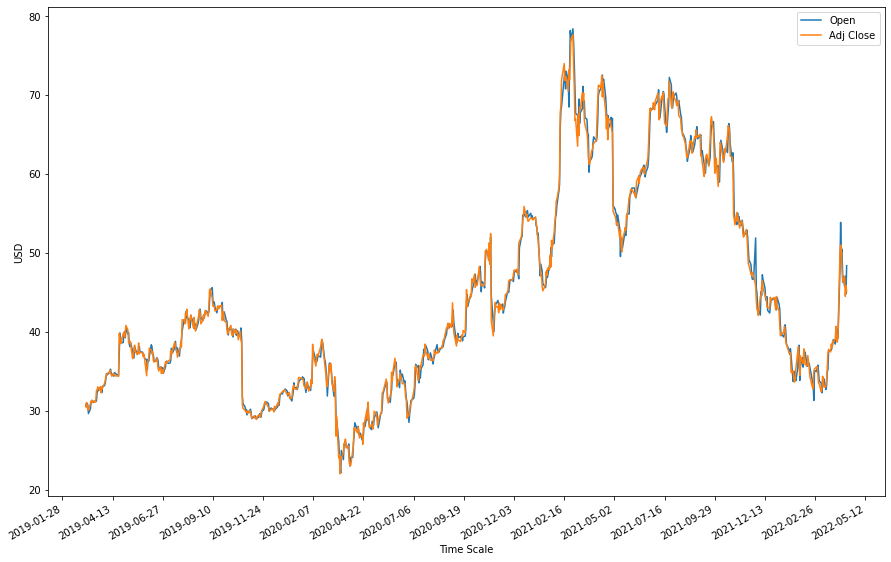

In [329]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['Open'], label='Open')
plt.plot(x_dates, data['Adj Close'], label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## High low

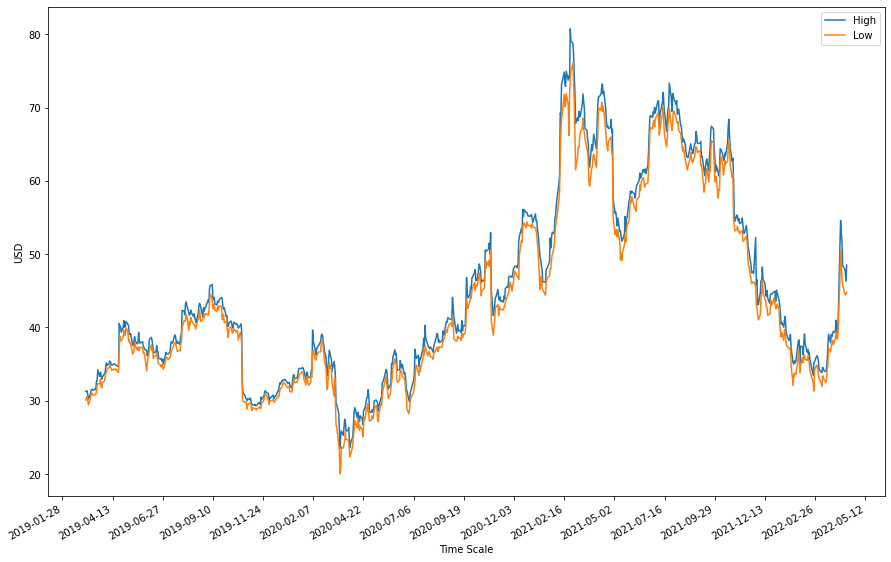

In [330]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))

x_dates=data_dates
plt.plot(x_dates, data['High'], label='High')
plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## Fyrsta módel

### Gagnaundirbúningur

In [331]:
target_y = data['Adj Close']
X_feat= data.iloc[:,0:5]
y_feat=data.iloc[:,4]

In [332]:
y_feat

Date
2019-03-04    30.500000
2019-03-05    31.030001
2019-03-06    30.799999
2019-03-07    30.120001
2019-03-08    30.040001
                ...    
2022-04-08    46.230000
2022-04-11    47.009998
2022-04-12    44.480000
2022-04-13    45.849998
2022-04-14    45.080002
Name: Adj Close, Length: 788, dtype: float64

In [333]:
X_feat

,Open,High,Low,Close,Adj Close
Date,,,,,
2019-03-04,30.780001,31.260000,30.070000,30.500000,30.500000
2019-03-05,30.500000,31.230000,30.389999,31.030001,31.030001
2019-03-06,30.940001,31.340000,30.590000,30.799999,30.799999
2019-03-07,30.760000,30.840000,30.010000,30.120001,30.120001
2019-03-08,29.639999,30.209999,29.410000,30.040001,30.040001
...,...,...,...,...,...
2022-04-08,47.299999,48.439999,45.830002,46.230000,46.230000
2022-04-11,45.750000,47.980000,44.709999,47.009998,47.009998
2022-04-12,47.029999,47.549999,44.439999,44.480000,44.480000


In [334]:
y_ft=np.array(y_feat)
y_ft=y_ft.reshape(-1,1)

In [335]:
sc= StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns=X_feat.columns, data=X_ft,index=X_feat.index)


In [336]:
y_ft=sc.fit_transform(y_ft)

In [337]:
def lstm_split(data, n_steps1):
  X, y=[], []
  for i in range(len(data)-n_steps1+1):
    X.append(data[i:i+n_steps1,:-1])
    y.append(data[i+n_steps1-1,-1])

  return np.array(X), np.array(y)


In [338]:
X11, y11= lstm_split(X_ft.values, n_steps1=1)

train_split=0.8
split_idx= int(np.ceil(len(X11)*train_split))
date_index=X_ft.index

Xtr1, Xtst1= X11[:split_idx], X11[split_idx:]
ytr1, ytst1= y11[:split_idx], y11[split_idx:]
Xtrd1, Xtstd1= date_index[:split_idx], date_index[split_idx:]

print(X11.shape, Xtr1.shape, Xtst1.shape, ytst1.shape)

(788, 1, 4) (631, 1, 4) (157, 1, 4) (157,)


### Modelið

In [339]:
model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr1.shape[1],Xtr1.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
model1.compile(loss="mean_squared_error", optimizer="adam")
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 1, 32)             4736      
                                                                 
 lstm_28 (LSTM)              (None, 32)                8320      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


In [340]:
history1=model1.fit(Xtr1,ytr1,epochs=100,validation_data=(Xtst1, ytst1),batch_size=4,verbose=2,shuffle=False)

Epoch 1/100
158/158 - 4s - loss: 0.4048 - val_loss: 0.0121 - 4s/epoch - 27ms/step
Epoch 2/100
158/158 - 1s - loss: 0.0046 - val_loss: 0.0038 - 651ms/epoch - 4ms/step
Epoch 3/100
158/158 - 1s - loss: 0.0043 - val_loss: 0.0036 - 609ms/epoch - 4ms/step
Epoch 4/100
158/158 - 1s - loss: 0.0041 - val_loss: 0.0035 - 598ms/epoch - 4ms/step
Epoch 5/100
158/158 - 1s - loss: 0.0038 - val_loss: 0.0035 - 613ms/epoch - 4ms/step
Epoch 6/100
158/158 - 1s - loss: 0.0035 - val_loss: 0.0034 - 603ms/epoch - 4ms/step
Epoch 7/100
158/158 - 1s - loss: 0.0034 - val_loss: 0.0034 - 601ms/epoch - 4ms/step
Epoch 8/100
158/158 - 1s - loss: 0.0032 - val_loss: 0.0035 - 579ms/epoch - 4ms/step
Epoch 9/100
158/158 - 1s - loss: 0.0032 - val_loss: 0.0037 - 616ms/epoch - 4ms/step
Epoch 10/100
158/158 - 1s - loss: 0.0034 - val_loss: 0.0039 - 652ms/epoch - 4ms/step
Epoch 11/100
158/158 - 1s - loss: 0.0036 - val_loss: 0.0042 - 616ms/epoch - 4ms/step
Epoch 12/100
158/158 - 1s - loss: 0.0039 - val_loss: 0.0047 - 583ms/epoch - 

In [341]:
ypr=model1.predict(Xtst1)


### Lærdómskúrva

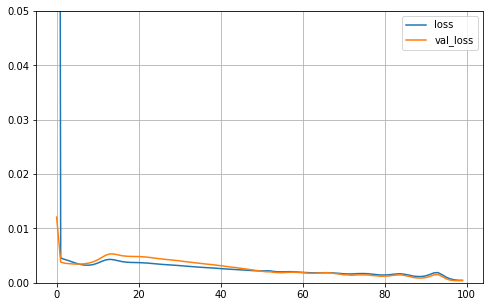

In [342]:
pd.DataFrame(history1.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.05)
plt.show()

### Samanburður á raunverulegu close og mati LSTM

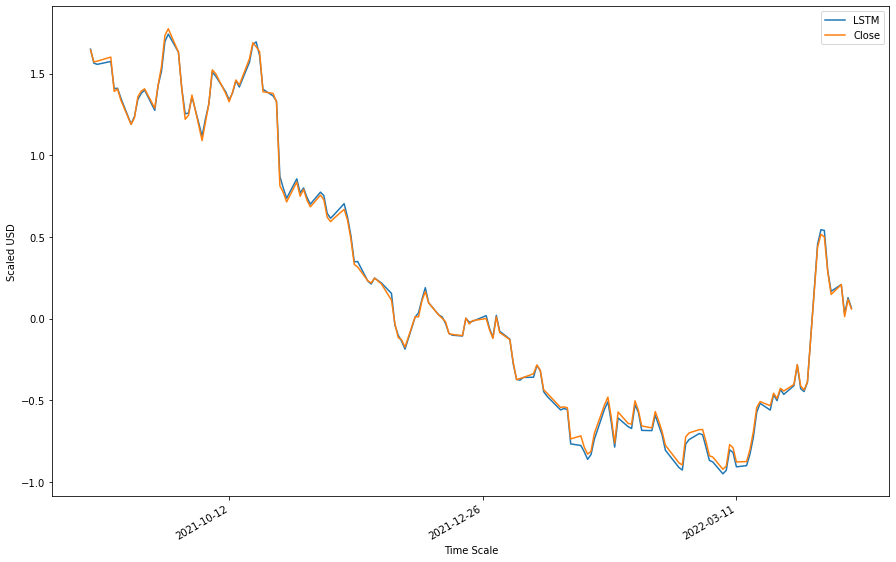

In [343]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
y=y_ft[k:]
plt.plot(x_dates, ypr, label='LSTM')
plt.plot(x_dates, y, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [344]:
rmse=mean_squared_error(ytst1,ypr,squared=False)
mape=mean_absolute_percentage_error(ytst1,ypr)
print("RSME:",rmse)
print("MAPE:",mape)

RSME: 0.021123538847748084
MAPE: 0.852669470470767


In [345]:
Villa1 = (rmse+mape)/2

## Annað módel

### Þjálfun á modeli

In [346]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr1.shape[1],Xtr1.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
model2.compile(loss="mean_squared_error", optimizer="adam")
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 1, 50)             11000     
                                                                 
 lstm_30 (LSTM)              (None, 1, 50)             20200     
                                                                 
 lstm_31 (LSTM)              (None, 50)                20200     
                                                                 
 dense_12 (Dense)            (None, 1)                 51        
                                                                 
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
_________________________________________________________________


In [347]:
history2 = model2.fit(Xtr1, ytr1, epochs=100, batch_size=50, validation_data=(Xtst1, ytst1), verbose=2, shuffle=False)

Epoch 1/100
13/13 - 7s - loss: 1.0470 - val_loss: 0.7102 - 7s/epoch - 560ms/step
Epoch 2/100
13/13 - 0s - loss: 0.9490 - val_loss: 0.6304 - 99ms/epoch - 8ms/step
Epoch 3/100
13/13 - 0s - loss: 0.7685 - val_loss: 0.4618 - 108ms/epoch - 8ms/step
Epoch 4/100
13/13 - 0s - loss: 0.4544 - val_loss: 0.2003 - 96ms/epoch - 7ms/step
Epoch 5/100
13/13 - 0s - loss: 0.1168 - val_loss: 0.0115 - 110ms/epoch - 8ms/step
Epoch 6/100
13/13 - 0s - loss: 0.0255 - val_loss: 0.0414 - 97ms/epoch - 7ms/step
Epoch 7/100
13/13 - 0s - loss: 0.0187 - val_loss: 0.0186 - 93ms/epoch - 7ms/step
Epoch 8/100
13/13 - 0s - loss: 0.0161 - val_loss: 0.0089 - 96ms/epoch - 7ms/step
Epoch 9/100
13/13 - 0s - loss: 0.0140 - val_loss: 0.0114 - 97ms/epoch - 7ms/step
Epoch 10/100
13/13 - 0s - loss: 0.0135 - val_loss: 0.0133 - 103ms/epoch - 8ms/step
Epoch 11/100
13/13 - 0s - loss: 0.0130 - val_loss: 0.0115 - 97ms/epoch - 7ms/step
Epoch 12/100
13/13 - 0s - loss: 0.0125 - val_loss: 0.0112 - 100ms/epoch - 8ms/step
Epoch 13/100
13/13 - 

In [348]:
ypr2=model2.predict(Xtst1)

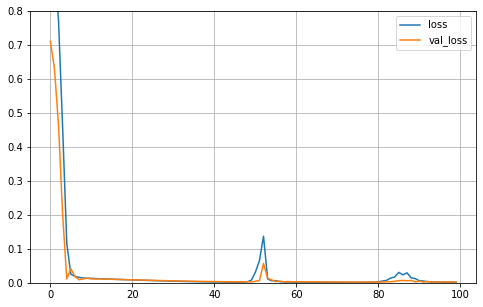

In [349]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður á raunverulegu og LSTM

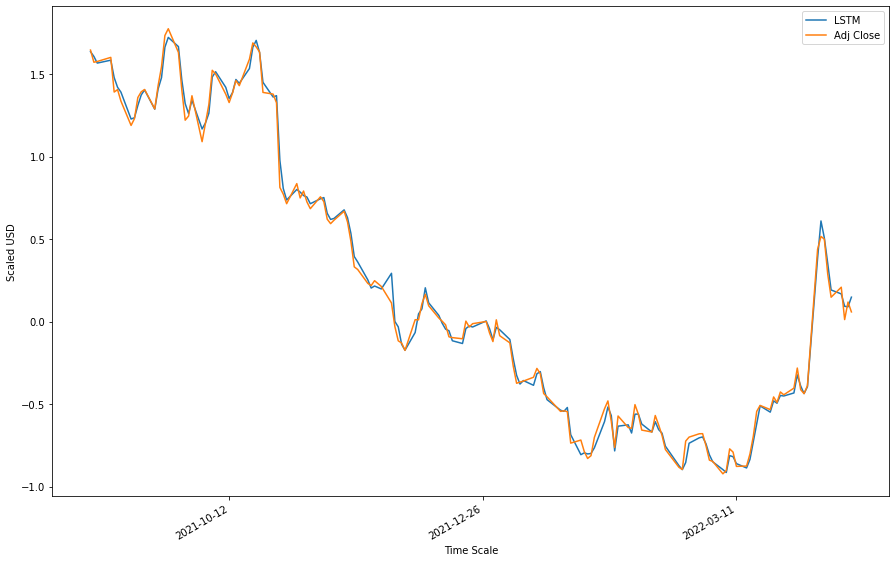

In [350]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr1)
x_dates=data_dates[k:]
y=y_ft[k:]
plt.plot(x_dates, ypr2, label='LSTM')
plt.plot(x_dates, y, label='Adj Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE VILLA

In [351]:
rmse2=mean_squared_error(ytst1,ypr2,squared=False)
mape2=mean_absolute_percentage_error(ytst1,ypr2)
print("RSME:",rmse2)
print("MAPE:",mape2)

RSME: 0.04351195282753313
MAPE: 0.5602498103050857


In [352]:
Villa2=(rmse2+mape2)/2

## Þriðja módel

### Þjálfun

In [353]:
n_steps1=100
X12, y12= lstm_split(X_ft.values, n_steps1=n_steps1)

train_split=0.8
split_idx= int(np.ceil(len(X12)*train_split))
date_index=X_ft.index

Xtr2, Xtst2= X12[:split_idx], X12[split_idx:]
ytr2, ytst2= y12[:split_idx], y12[split_idx:]
Xtrd2, Xtstd2= date_index[:split_idx], date_index[split_idx:-n_steps1+1]

print(X12.shape, Xtr2.shape, Xtst2.shape,Xtstd2.shape, ytst2.shape)

(689, 100, 4) (552, 100, 4) (137, 100, 4) (137,) (137,)


In [354]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)])
model3.compile(loss="mean_squared_error", optimizer="adam")

In [355]:
history3 = model3.fit(Xtr2, ytr2, epochs=100, batch_size=50, validation_data=(Xtst2, ytst2), verbose=2, shuffle=False)

Epoch 1/100
12/12 - 6s - loss: 0.2727 - val_loss: 0.2451 - 6s/epoch - 511ms/step
Epoch 2/100
12/12 - 1s - loss: 0.2337 - val_loss: 0.0784 - 1s/epoch - 113ms/step
Epoch 3/100
12/12 - 1s - loss: 0.3377 - val_loss: 0.0608 - 1s/epoch - 108ms/step
Epoch 4/100
12/12 - 1s - loss: 0.1147 - val_loss: 0.1417 - 1s/epoch - 108ms/step
Epoch 5/100
12/12 - 1s - loss: 0.1240 - val_loss: 0.0657 - 1s/epoch - 108ms/step
Epoch 6/100
12/12 - 1s - loss: 0.1165 - val_loss: 0.0666 - 1s/epoch - 107ms/step
Epoch 7/100
12/12 - 1s - loss: 0.0993 - val_loss: 0.0680 - 1s/epoch - 109ms/step
Epoch 8/100
12/12 - 1s - loss: 0.0991 - val_loss: 0.0537 - 1s/epoch - 109ms/step
Epoch 9/100
12/12 - 1s - loss: 0.1154 - val_loss: 0.0552 - 1s/epoch - 109ms/step
Epoch 10/100
12/12 - 1s - loss: 0.1049 - val_loss: 0.0610 - 1s/epoch - 112ms/step
Epoch 11/100
12/12 - 1s - loss: 0.0978 - val_loss: 0.0483 - 1s/epoch - 110ms/step
Epoch 12/100
12/12 - 1s - loss: 0.1000 - val_loss: 0.0618 - 1s/epoch - 109ms/step
Epoch 13/100
12/12 - 1s -

In [356]:
ypr3=model3.predict(Xtst2)

### Lærdómskúrva

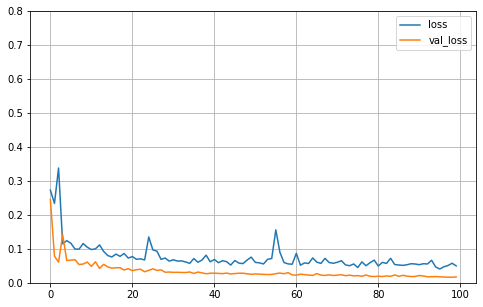

In [357]:
pd.DataFrame(history3.history).plot(figsize=(8,5))
plt.grid()
plt.gca().set_ylim(0, 0.8)
plt.show()

### Samanburður á raunverulegu og LSTM

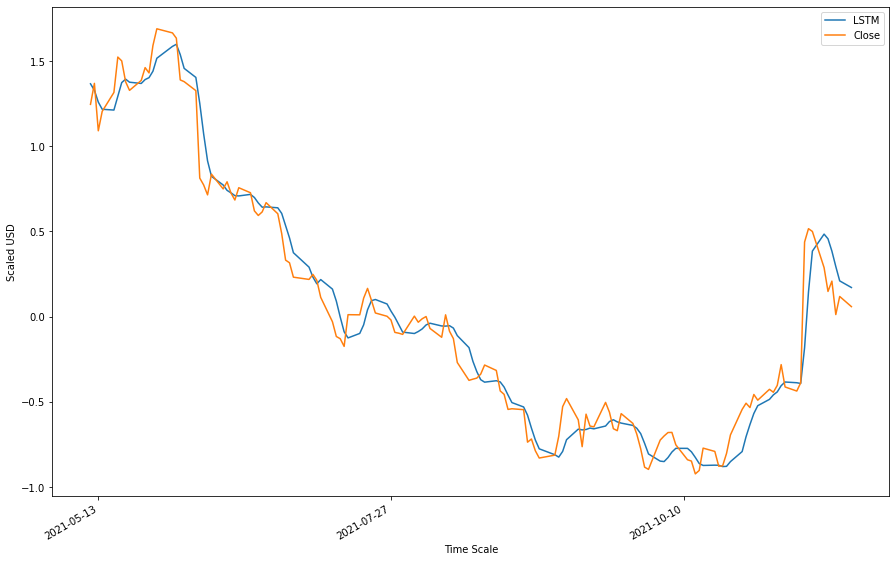

In [358]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
k=len(Xtr2)
thri=len(X12)-len(Xtstd2)
x_dates=data_dates[k:]
n=n_steps1-1
y=y_ft[thri+n:]
plt.plot(Xtstd2, ypr3, label='LSTM')
plt.plot(Xtstd2, y, label='Close')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### RMSE OG MAPE

In [359]:
rmse3=mean_squared_error(ytst2,ypr3,squared=False)
mape3=mean_absolute_percentage_error(ytst2,ypr3)
print("RSME:",rmse3)
print("MAPE:",mape3)

RSME: 0.13160869489221771
MAPE: 3.793495909457115


In [360]:
Villa3=(rmse3+mape3)/2

## SMA (Simple Moving Average) samanburður við raunverulegt





Test RMSE: 19.619
Test MAPE: 0.424


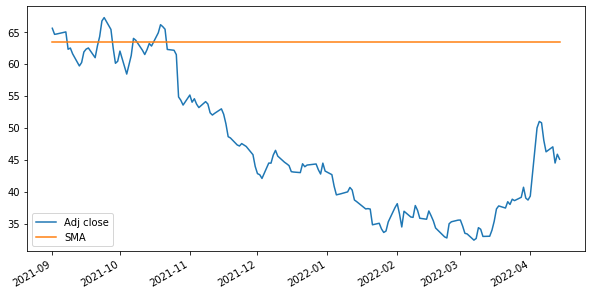

In [404]:
train_split=0.8
split_idx2= int(np.ceil(len(data)*train_split))
tr=data[['Adj Close']].iloc[:split_idx2]
tst=data[['Adj Close']].iloc[split_idx2:]

tstpr=np.array([tr.rolling(10).mean().iloc[-1]]*len(tst)).reshape((-1,1))

print('Test RMSE: %.3f'%mean_squared_error(tst,tstpr,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst,tstpr))
f=len(tst)-len(y)
z=n-f
x_dates=data_dates[k+z:]


plt.figure(figsize=(10,5))
plt.plot(x_dates, tst, label='Adj close')
plt.plot(x_dates, tstpr, label='SMA')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

## EMA (Exponential moving average) samanburður við raunverulegt

Test RMSE: 20.091
Test MAPE: 0.435


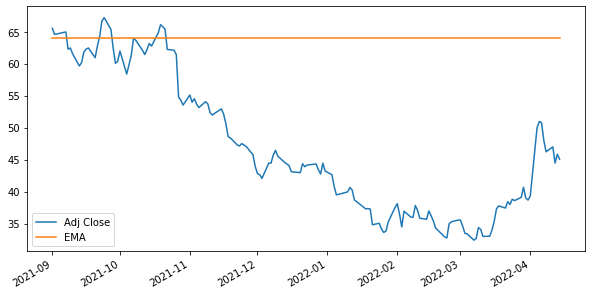

In [403]:
from statsmodels.tsa.api import SimpleExpSmoothing

J=data[['Adj Close']].values
train_split=0.8
split_idx3= int(np.ceil(len(J)*train_split))
tr2=J[:split_idx3]
tst2=J[split_idx3:]
tst_concat=np.array([]).reshape((0,1))

for i in range(len(tst2)):
  tr_fit=np.concatenate((tr2,np.asarray(tst_concat)))
  fit=SimpleExpSmoothing(np.asarray(tr_fit)).fit(smoothing_level=0.2)
  tst_pr=fit.forecast(1)
  tst_concat=np.concatenate((np.asarray(tst_concat),tst_pr.reshape((-1,1))))

print('Test RMSE: %.3f'%mean_squared_error(tst2,tst_concat,squared=False))
print('Test MAPE: %.3f'%mean_absolute_percentage_error(tst2,tst_concat))
f=len(tst2)-len(y)
z=n-f
x_dates=data_dates[k+z:]

plt.figure(figsize=(10,5))
plt.plot(x_dates, tst2, label='Adj Close')
plt.plot(x_dates, tst_concat, label='EMA')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()


## Val á modeli með minnstu villuna

In [363]:
smallest = 0
if Villa1 < Villa2 and Villa1 < Villa3 :
    smallest = 'Model1'
if Villa2 < Villa1 and Villa2 < Villa3 :
    smallest = 'Model2'
if Villa3 < Villa1 and Villa3 < Villa2 :
    smallest = 'Model3'
print(smallest, "er með minnstu samanlögðu meðalvilluna.")
print("Við veljum þá", smallest)

Model2 er með minnstu samanlögðu meðalvilluna.
Við veljum þá Model2


## Framtíðarspáin

### val á gögnum

In [364]:
spagogn=data.reset_index()['Close']
spagogn.shape

(788,)

### Mynd af gögnum sem voru valin

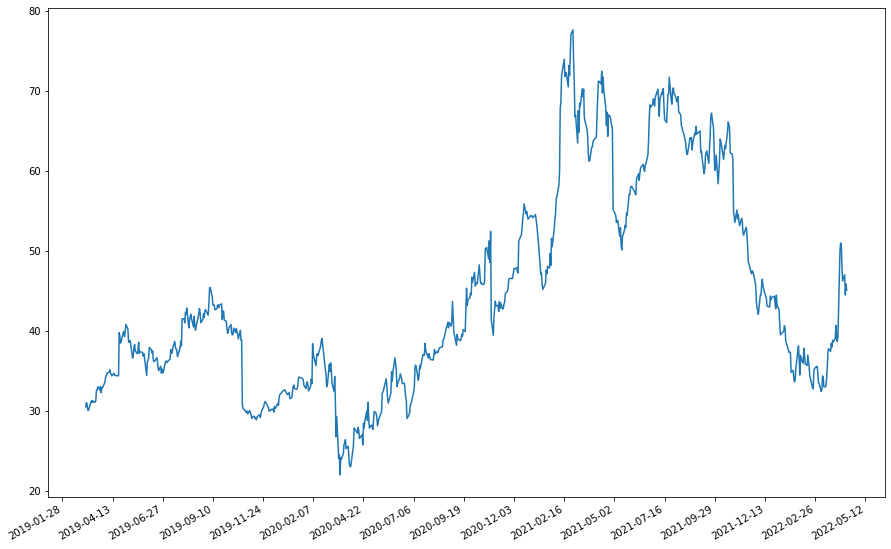

In [365]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=75))
x_dates=data_dates
plt.plot(x_dates, spagogn, label='Close')
plt.gcf().autofmt_xdate()

### Gagnavinnsla

In [366]:
scaler=MinMaxScaler(feature_range=(0,1))
spagogn=scaler.fit_transform(np.array(spagogn).reshape(-1,1))

In [367]:
trainstaerd=int(len(spagogn)*0.65)
tststaerd=len(spagogn)-trainstaerd
train_data,test_data=spagogn[0:trainstaerd,:],spagogn[trainstaerd:len(spagogn),:1]

In [368]:
trainstaerd,tststaerd

(512, 276)

In [370]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [371]:
time_step = 100
Xtr3, ytr3 = create_dataset(train_data, time_step)
Xtst3, ytst3 = create_dataset(test_data, time_step)

In [374]:
Xtr3 =Xtr3.reshape(Xtr3.shape[0],Xtr3.shape[1] , 1)
Xtst3 = Xtst3.reshape(Xtst3.shape[0],Xtst3.shape[1] , 1)

### Modelið

In [377]:

if smallest=='Model1' :
    print("Við notum Model1")
    model1 = keras.models.Sequential([
    keras.layers.LSTM(32,input_shape=(Xtr3.shape[1],Xtr3.shape[2]), activation="relu",return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)])
    model1.compile(loss="mean_squared_error", optimizer="adam")
    model1.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=4,verbose=2)   
if smallest=='Model2' :
    print("Við notum Model2")
    model2 = keras.models.Sequential([
    keras.layers.LSTM(50,input_shape=(Xtr3.shape[1],Xtr3.shape[2]),return_sequences=True),
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)])
    model2.compile(loss="mean_squared_error", optimizer="adam")
    model2.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 
if smallest=='Model3' :
    print("Við notum Model3")
    model3 = keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=True),
    keras.layers.Dropout(0.5),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1)])
    model3.compile(loss="mean_squared_error", optimizer="adam")
    model3.fit(Xtr3,ytr3,validation_data=(Xtst3,ytst3),epochs=100,batch_size=50,verbose=2) 

Við notum Model2
Epoch 1/100
9/9 - 9s - loss: 0.0564 - val_loss: 0.0213 - 9s/epoch - 1s/step
Epoch 2/100
9/9 - 2s - loss: 0.0138 - val_loss: 0.0123 - 2s/epoch - 175ms/step
Epoch 3/100
9/9 - 2s - loss: 0.0091 - val_loss: 0.0116 - 2s/epoch - 175ms/step
Epoch 4/100
9/9 - 2s - loss: 0.0066 - val_loss: 0.0046 - 2s/epoch - 178ms/step
Epoch 5/100
9/9 - 2s - loss: 0.0057 - val_loss: 0.0192 - 2s/epoch - 178ms/step
Epoch 6/100
9/9 - 2s - loss: 0.0059 - val_loss: 0.0097 - 2s/epoch - 179ms/step
Epoch 7/100
9/9 - 2s - loss: 0.0052 - val_loss: 0.0085 - 2s/epoch - 175ms/step
Epoch 8/100
9/9 - 2s - loss: 0.0055 - val_loss: 0.0119 - 2s/epoch - 177ms/step
Epoch 9/100
9/9 - 2s - loss: 0.0051 - val_loss: 0.0044 - 2s/epoch - 179ms/step
Epoch 10/100
9/9 - 2s - loss: 0.0049 - val_loss: 0.0092 - 2s/epoch - 177ms/step
Epoch 11/100
9/9 - 2s - loss: 0.0045 - val_loss: 0.0064 - 2s/epoch - 185ms/step
Epoch 12/100
9/9 - 2s - loss: 0.0043 - val_loss: 0.0043 - 2s/epoch - 175ms/step
Epoch 13/100
9/9 - 2s - loss: 0.004

### Spágögn búin til

In [378]:
mod=0
if smallest=='Model1' :
  trspa=model1.predict(Xtr3)
  tstspa=model1.predict(Xtst3)
  mod=model1
if smallest=='Model2' :
  trspa=model2.predict(Xtr3)
  tstspa=model2.predict(Xtst3)
  mod=model2
if smallest=='Model3' :
  trspa=model3.predict(Xtr3)
  tstspa=model3.predict(Xtst3)
  mod=model3

In [379]:
trspa=scaler.inverse_transform(trspa)
tstspa=scaler.inverse_transform(tstspa)

### RMSE 

In [380]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(ytr3,trspa))

41.053021493694146

In [381]:
### Spágögn RMSE
math.sqrt(mean_squared_error(ytst3,tstspa))

56.85369075246086

### Train spá og test spá

In [382]:
# shift train predictions for plotting
look_back=100
allt = np.empty_like(spagogn)
allt[:, :] = np.nan
allt[look_back:len(trspa)+look_back, :] = trspa

In [383]:
# shift test predictions for plotting
trainspa = np.empty_like(spagogn)
trainspa[:, :] = np.nan
trainspa[len(trspa)+(look_back*2)+1:len(spagogn)-1, :] = tstspa
testspa=scaler.inverse_transform(spagogn)
x_dates=data_dates

### Mynd af öllu gagnasettinu með test og training gögnum

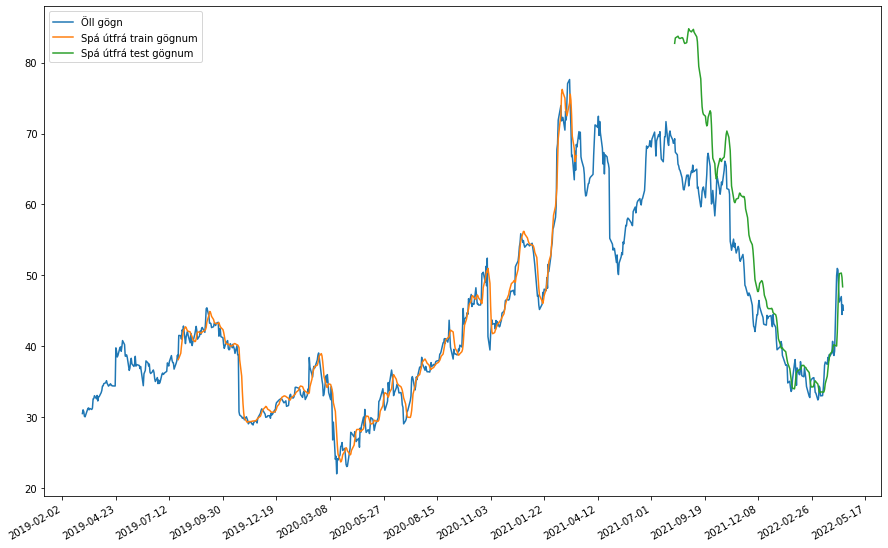

In [384]:
x_dates=data_dates
# plot baseline and predictions
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=80))
plt.plot(data_dates,testspa,label='Spá útfrá test gögnum')
plt.plot(data_dates,allt, label='Öll gögn')
plt.plot(data_dates,trainspa,label='Spá útfrá train gögnum')
plt.legend(['Öll gögn', 'Spá útfrá train gögnum','Spá útfrá test gögnum'],loc='upper left')
plt.gcf().autofmt_xdate()
plt.show()

### Framtíðargögn sett í fylki

In [385]:
len(test_data)

276

In [386]:
timi=len(test_data)-100


In [387]:
x_input=test_data[timi:].reshape(1,-1)
x_input.shape

(1, 100)

In [388]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [389]:
#temp_input

In [ ]:
frspa=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = mod.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        frspa.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = mod.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        frspa.extend(yhat.tolist())
        i=i+1
    

#print(frspa)

In [391]:
len(spagogn)

788

In [406]:
tim=len(spagogn)-100

### Mynd af spá ósamsett

In [407]:
fdata = pd.concat([data, future_dates], axis=0)
framtid=fdata.index.to_frame().reset_index(drop=True)
framtid=framtid.apply(pd.to_datetime)
len(framtid)

819

In [408]:
spat=len(framtid)-30
sidf=len(framtid)-130

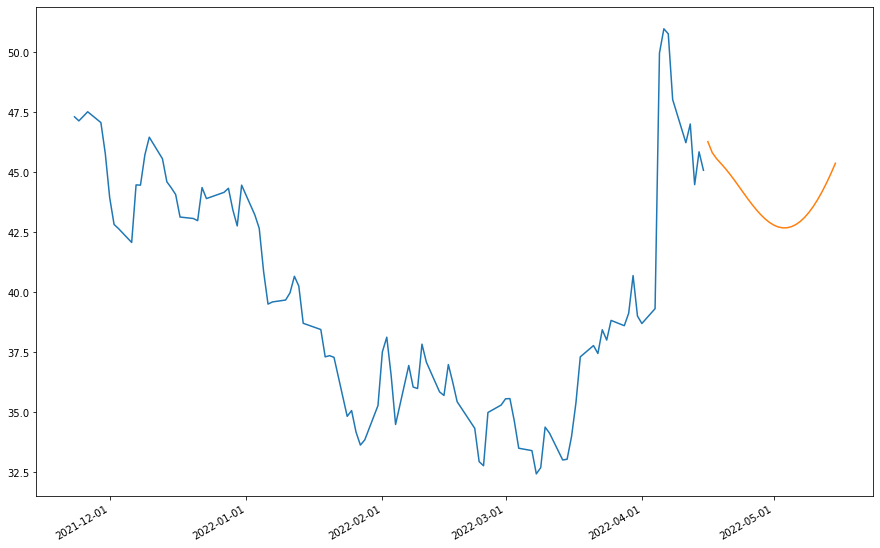

In [409]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
plt.plot(framtid[sidf:spat],scaler.inverse_transform(spagogn[tim:]))
plt.plot(framtid[spat:],scaler.inverse_transform(frspa))
plt.gcf().autofmt_xdate()

In [410]:
timm=tim+30

In [411]:
spgfr=spagogn.tolist()
spgfr.extend(frspa)

In [412]:
laga=0
if len(framtid)!=len(spgfr):
  laga=len(framtid)-len(spgfr)


### Mynd af spá samsett

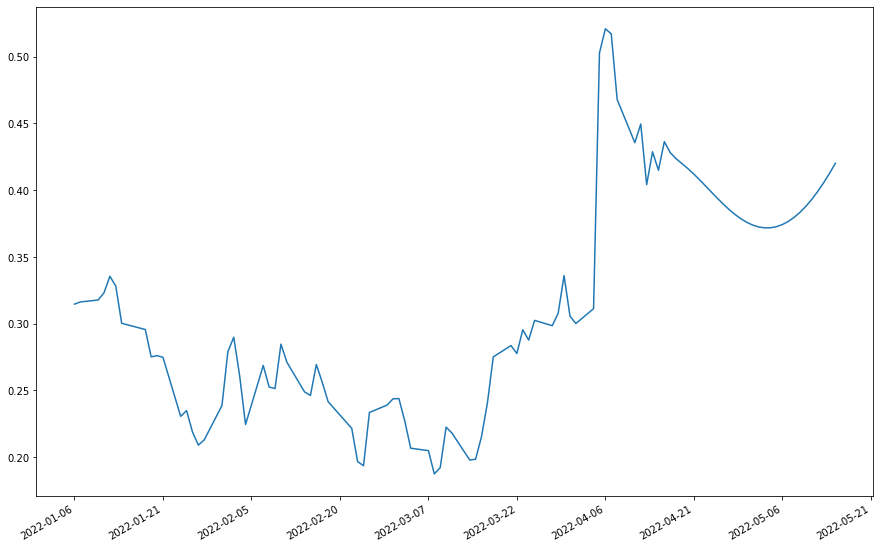

In [413]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.plot(framtid[timm+laga:],spgfr[timm:])
plt.gcf().autofmt_xdate()

In [419]:
spgfr=scaler.inverse_transform(spgfr).tolist()

### Mynd af heildargögnum með spá

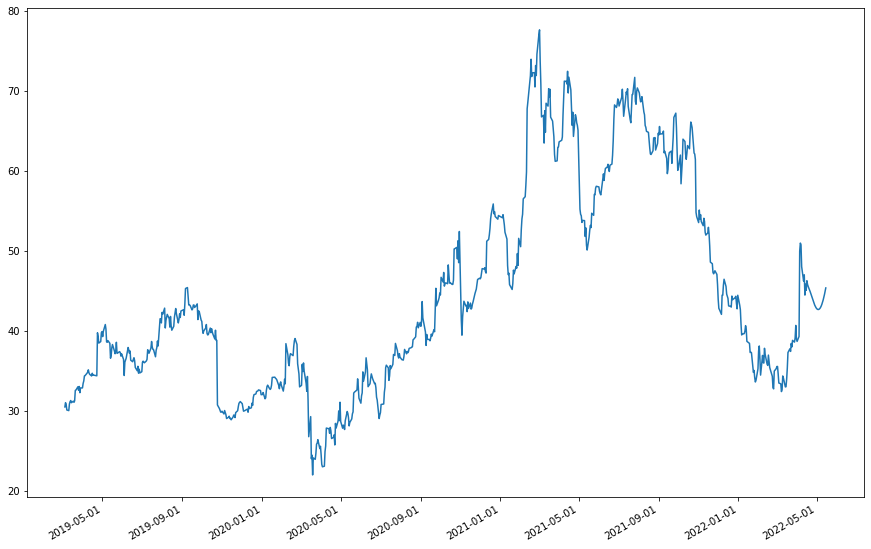

In [420]:
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=105))
plt.plot(framtid[laga:],spgfr)
plt.gcf().autofmt_xdate()